In [1]:
import os
from glob import glob
import time
import re
import argparse
import nibabel as nib
import pandas as pd
from medpy.metric.binary import hd, dc
import numpy as np

HEADER = ["Name", "Dice LV", "Volume LV", "Err LV(ml)",
          "Dice RV", "Volume RV", "Err RV(ml)",
          "Dice MYO", "Volume MYO", "Err MYO(ml)"]

def conv_int(i):
    return int(i) if i.isdigit() else i

def natural_order(sord):
    """
    Sort a (list,tuple) of strings into natural order.

    Ex:

    ['1','10','2'] -> ['1','2','10']

    ['abc1def','ab10d','b2c','ab1d'] -> ['ab1d','ab10d', 'abc1def', 'b2c']

    """
    if isinstance(sord, tuple):
        sord = sord[0]
    return [conv_int(c) for c in re.split(r'(\d+)', sord)]

### Utils functions used to sort strings into a natural order

In [2]:

def load_nii(img_path):
    """
    Function to load a 'nii' or 'nii.gz' file, The function returns
    everyting needed to save another 'nii' or 'nii.gz'
    in the same dimensional space, i.e. the affine matrix and the header

    Parameters
    ----------

    img_path: string
    String with the path of the 'nii' or 'nii.gz' image file name.

    Returns
    -------
    Three element, the first is a numpy array of the image values,
    the second is the affine transformation of the image, and the
    last one is the header of the image.
    """
    nimg = nib.load(img_path)
    return nimg.get_data(), nimg.affine, nimg.header


def save_nii(img_path, data, affine, header):
    """
    Function to save a 'nii' or 'nii.gz' file.

    Parameters
    ----------

    img_path: string
    Path to save the image should be ending with '.nii' or '.nii.gz'.

    data: np.array
    Numpy array of the image data.

    affine: list of list or np.array
    The affine transformation to save with the image.

    header: nib.Nifti1Header
    The header that define everything about the data
    (pleasecheck nibabel documentation).
    """
    nimg = nib.Nifti1Image(data, affine=affine, header=header)
    nimg.set_data_dtype(np.uint8)
    nimg.to_filename(img_path)

In [3]:
import albumentations as A
from random import randint
from PIL import Image

def Auto_ZeroPadding2D(height,width,img):
    proportion = False
    proportion = height/img.shape[0]
    if proportion > width/img.shape[1]:
        proportion = width/img.shape[1]
        
    init_size = (img.shape[1],img.shape[0])
    img = cv2.resize(img, (int(img.shape[1]*proportion),int(img.shape[0]*proportion)))
    second_size = img.shape

    if (height-img.shape[0]) % 2 != 0:
        _top = (height-img.shape[0])//2
        _bottom = _top+1
    else:
        _top = (height-img.shape[0])//2
        _bottom = _top

    if (width-img.shape[1]) % 2 != 0:
        _left = (width-img.shape[1])//2
        _right = _left+1
    else:
        _left = (width-img.shape[1])//2
        _right = _left

    new_im = Image.new('RGB', (width, height), (0, 0, 0, 0))
    if len(img.shape)!=3:
        new_im = new_im.convert('L')

    img = Image.fromarray(img)
    new_im.paste(img, (_left,_top))
    new_im = np.array(new_im)
    return new_im, init_size, second_size, _left, _top


In [4]:
import keras
import imageio
import cv2
import matplotlib.pyplot as plt
from keras.utils import np_utils
import segmentation_models as sm
import tensorflow as tf
from swa.tfkeras import SWA
import pickle

# SEGMENTATION MODEL

from keras.applications import keras_applications
from keras_applications.mobilenet_v3 import MobileNetV3Large

# UNET BLOCK
def unet_decoder_block(input, filters, skip, stage):

    x = keras.layers.UpSampling2D((2, 2), name='decoder_stage{}_upsampling'.format(stage))(input)

    if skip is not None:
        x = keras.layers.Concatenate(name='decoder_stage{}_concat'.format(stage))([x, skip])

    x = keras.layers.Conv2D(filters, kernel_size=(3,3), padding='same', strides=1, use_bias=False, name='decoder_stage{}a_conv'.format(stage))(x)
    x = keras.layers.BatchNormalization(axis=3, name='decoder_stage{}a_bn'.format(stage))(x)
    x = keras.layers.Activation('relu', name='decoder_stage{}a_relu'.format(stage))(x)

    x = keras.layers.Conv2D(filters, kernel_size=(3,3), padding='same', strides=1, use_bias=False, name='decoder_stage{}b_conv'.format(stage))(x)
    x = keras.layers.BatchNormalization(axis=3, name='decoder_stage{}b_bn'.format(stage))(x)
    x = keras.layers.Activation('relu', name='decoder_stage{}b_relu'.format(stage))(x)

    return x

def MobileNetV3_Encoder(decoder=None, n_class=1):

    if decoder is None:
        return "Please choose your decoder block!"

    # GET MOBILENETV3 BACKBONE
    backbone = MobileNetV3Large(input_shape=(256,256,3), include_top=False, weights='imagenet', backend=keras.backend, layers=keras.layers, models=keras.models, utils=keras.utils)

    # RENAME LAYER TO SOLVE THE PROBLEM WHEN SAVING THE MODEL
    for i, layer in enumerate(backbone.layers):
        layer.name = 'layer_' + str(i)

    # GET SKIP CONNECTION
    skip1 = backbone.get_layer(index=13).output
    skip2 = backbone.get_layer(index=31).output
    skip3 = backbone.get_layer(index=79).output
    skip4 = backbone.get_layer(index=146).output

    if decoder.lower() == 'unet':
        # UNET DECODER BLOCK
        x = unet_decoder_block(backbone.output, 256, skip4, 0)
        x = unet_decoder_block(x, 128, skip3, 1)
        x = unet_decoder_block(x, 64, skip2, 2)
        x = unet_decoder_block(x, 32, skip1, 3)
        x = unet_decoder_block(x, 16, None, 4)

    if n_class == 1:
        x = keras.layers.Conv2D(1, kernel_size=(3,3), padding='same', strides=1, kernel_initializer="he_normal", name='final_conv')(x)
        output = keras.layers.Activation("sigmoid", name='mask')(x)
    elif n_class >= 2:
        x = keras.layers.Conv2D(n_class, kernel_size=(3,3), padding='same', strides=1, kernel_initializer="he_normal", name='final_conv')(x)
        output = keras.layers.Activation("softmax", name='mask')(x)

    model = keras.models.Model(inputs=backbone.input, outputs=output, name = 'MobileNetV3_{}'.format(decoder.title()))

    return model

def build_segmentation_model(decoder, lr, multiclass=False, trainable=False, weight_name='', weight_path=''):
    print('Build Multiclass Segmentation Model (4 Output)' if multiclass else 'Build Segmentation Model (3 Output)')
    if multiclass:
        segmentation_model = MobileNetV3_Encoder(decoder=decoder, n_class=4)
    else:
        segmentation_model = MobileNetV3_Encoder(decoder=decoder, n_class=3)

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    segmentation_loss = sm.losses.JaccardLoss(per_image=True)
    segmentation_metrics = [sm.metrics.IOUScore(threshold=0.5, per_image=True), sm.metrics.FScore(threshold=0.5, per_image=True), sm.metrics.Precision(threshold=0.5, per_image=True), sm.metrics.Recall(threshold=0.5, per_image=True)]

    segmentation_model.compile(optimizer=optimizer, loss=segmentation_loss, metrics=segmentation_metrics)

    if weight_name and weight_path:
        segmentation_model.load_weights(os.path.join(weight_path, weight_name))
    
    return segmentation_model, segmentation_loss, segmentation_metrics

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [5]:
PROJECT_PATH = r'D:/Penelitian Jantung/ACDC/'
OUTPUT_PATH = os.path.join(PROJECT_PATH, 'Output/Model training')
 
sm_model, sm_loss, sm_metrics = build_segmentation_model(decoder='unet', 
                                        lr=1e-3, 
                                        multiclass=True, 
                                        trainable=True, )

Build Multiclass Segmentation Model (4 Output)


c:\users\user\anaconda3\envs\acdc\lib\site-packages\keras_applications\mobilenet_v3.py:348: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Build Multiclass Segmentation Model (4 Output)


c:\users\user\anaconda3\envs\acdc\lib\site-packages\keras_applications\mobilenet_v3.py:348: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [ ]:
# Copyright 2017 Division of Medical Image Computing, German Cancer Research Center (DKFZ)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# https://github.com/MIC-DKFZ/ACDC2017/blob/master/test_set/create_final_submission_files.py

In [145]:
import scipy, numpy, shutil, os, nibabel, imageio, glob
import matplotlib.pyplot as plt 
import SimpleITK as sitk

for i in os.listdir('dataset/ACDC_Dataset/testing/'):
    tmp = None
    for img_path in glob.glob('dataset/ACDC_Dataset/testing/{}/patient*_frame*.nii.gz'.format(i)):
        if not tmp:
            tmp = 'ED'
        else:
            tmp = 'ES'
        data, affine, header = load_nii(img_path)
        raw_itk = sitk.ReadImage(img_path) ###
        img_path = img_path.replace('testing','testing_pred2')
        try:
            os.mkdir('/'.join(img_path.split('\\')[:-1]))
        except:
            pass
        
        ## AUTOZEROPAD & PREDICT
        data = np.uint8(data)
        data[data==85] = 1
        data[data==170] = 2
        data[data==255] = 3
        mask = np.zeros(data.shape)
        
        for im in range(data.shape[-1]):
            im2 = np.expand_dims(data[:,:,im],axis=-1)
            im2 = np.concatenate([im2,im2,im2],axis=-1)
            im2, init_size, second_size, left, top  = Auto_ZeroPadding2D(256,256,im2)
            
            im2 = sm_model.predict(np.array([im2/255]))[0]
            im2[...,0] = 0
            im2[...,1] = np.where(im2[...,1]>0.5,1,0)
            im2[...,2] = np.where(im2[...,2]>0.5,2,0)
            im2[...,3] = np.where(im2[...,3]>0.5,3,0)
            im2 = np.max(im2, axis=-1)
            
            im2 = im2[top:top+second_size[0],left:left+second_size[1]]
            im2 = cv2.resize(im2, init_size)
#             im2[im2==1] = 85 
#             im2[im2==2] = 170 
#             im2[im2==3] = 255
            mask[...,im] = np.uint8(im2)

#             plt.figure()
#             plt.imshow(im2,cmap='gray')  

#         raw = sitk.GetArrayFromImage(raw_itk)
#         print(raw.shape,mask.shape)
        mask = np.moveaxis(mask, -1, 0)
        mask = np.moveaxis(mask, 1, -1)
        itk_seg = sitk.GetImageFromArray(mask)
        itk_seg.CopyInformation(raw_itk)
        sitk.WriteImage(itk_seg, img_path[:-14]+tmp+img_path[-7:])
        print(img_path,tmp)

#         save_nii(img_path, mask, affine, header)

c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


dataset/ACDC_Dataset/testing_pred2/patient101\patient101_frame01.nii.gz ED
dataset/ACDC_Dataset/testing_pred2/patient101\patient101_frame14.nii.gz ES
dataset/ACDC_Dataset/testing_pred2/patient102\patient102_frame01.nii.gz ED
dataset/ACDC_Dataset/testing_pred2/patient102\patient102_frame13.nii.gz ES
dataset/ACDC_Dataset/testing_pred2/patient103\patient103_frame01.nii.gz ED
dataset/ACDC_Dataset/testing_pred2/patient103\patient103_frame11.nii.gz ES
dataset/ACDC_Dataset/testing_pred2/patient104\patient104_frame01.nii.gz ED
dataset/ACDC_Dataset/testing_pred2/patient104\patient104_frame11.nii.gz ES
dataset/ACDC_Dataset/testing_pred2/patient105\patient105_frame01.nii.gz ED
dataset/ACDC_Dataset/testing_pred2/patient105\patient105_frame10.nii.gz ES
dataset/ACDC_Dataset/testing_pred2/patient106\patient106_frame01.nii.gz ED
dataset/ACDC_Dataset/testing_pred2/patient106\patient106_frame13.nii.gz ES
dataset/ACDC_Dataset/testing_pred2/patient107\patient107_frame01.nii.gz ED
dataset/ACDC_Dataset/test

In [9]:
import scipy, numpy, shutil, os, nibabel, imageio, glob
import matplotlib.pyplot as plt 

for i in os.listdir('dataset/ACDC_Dataset/training/'):
    for img_path in glob.glob('dataset/ACDC_Dataset/training/{}/patient*_frame*.nii.gz'.format(i)):
        data, affine, header = load_nii(img_path)
        img_path = img_path.replace('training','training_pred')
        try:
            os.mkdir('/'.join(img_path.split('\\')[:-1]))
        except:
            pass
        
        ## AUTOZEROPAD & PREDICT
        data = np.uint8(data)
        data[data==85] = 1
        data[data==170] = 2
        data[data==255] = 3
        mask = np.zeros(data.shape)
        
        for im in range(data.shape[-1]):
            im2 = np.expand_dims(data[:,:,im],axis=-1)
            im2 = np.concatenate([im2,im2,im2],axis=-1)
            im2, init_size, second_size, left, top  = Auto_ZeroPadding2D(256,256,im2)
            
            im2 = sm_model.predict(np.array([im2/255]))[0]
            im2[...,0] = 0
            im2[...,1] = np.where(im2[...,1]>0.5,1,0)
            im2[...,2] = np.where(im2[...,2]>0.5,2,0)
            im2[...,3] = np.where(im2[...,3]>0.5,3,0)
            im2 = np.max(im2, axis=-1)
            
            im2 = im2[top:top+second_size[0],left:left+second_size[1]]
            im2 = cv2.resize(im2, init_size)
            im2[im2==1] = 85 
            im2[im2==2] = 170 
            im2[im2==3] = 255
            mask[...,im] = np.uint8(im2)
            
#             plt.figure()
#             plt.imshow(im2,cmap='gray')
            
        save_nii(img_path, mask, affine, header)

c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going 

c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going 

c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going 

c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going 

c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going 

c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going 

c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going 

c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going 

c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going 

c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going 

c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going 

c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going 

c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going 

### Functions to process files, directories and metrics

In [56]:

def metrics(img_gt, img_pred, voxel_size):
    """
    Function to compute the metrics between two segmentation maps given as input.

    Parameters
    ----------
    img_gt: np.array
    Array of the ground truth segmentation map.

    img_pred: np.array
    Array of the predicted segmentation map.

    voxel_size: list, tuple or np.array
    The size of a voxel of the images used to compute the volumes.

    Return
    ------
    A list of metrics in this order, [Dice LV, Volume LV, Err LV(ml),
    Dice RV, Volume RV, Err RV(ml), Dice MYO, Volume MYO, Err MYO(ml)]
    """

    if img_gt.ndim != img_pred.ndim:
        raise ValueError("The arrays 'img_gt' and 'img_pred' should have the "
                         "same dimension, {} against {}".format(img_gt.ndim,
                                                                img_pred.ndim))

    res = []
    # Loop on each classes of the input images
    for c in [3, 1, 2]:
        # Copy the gt image to not alterate the input
        gt_c_i = np.copy(img_gt)
        gt_c_i[gt_c_i != c] = 0

        # Copy the pred image to not alterate the input
        pred_c_i = np.copy(img_pred)
        pred_c_i[pred_c_i != c] = 0

        # Clip the value to compute the volumes
        gt_c_i = np.clip(gt_c_i, 0, 1)
        pred_c_i = np.clip(pred_c_i, 0, 1)

        # Compute the Dice
        dice = dc(gt_c_i, pred_c_i)

        # Compute volume
        volpred = pred_c_i.sum() * np.prod(voxel_size) / 1000.
        volgt = gt_c_i.sum() * np.prod(voxel_size) / 1000.

        res += [dice, volpred, volpred-volgt]

    return res


def compute_metrics_on_files(path_gt, path_pred):
    """
    Function to give the metrics for two files

    Parameters
    ----------

    path_gt: string
    Path of the ground truth image.

    path_pred: string
    Path of the predicted image.
    """
    gt, _, header = load_nii(path_gt)
    pred, _, _ = load_nii(path_pred)
    zooms = header.get_zooms()

    name = os.path.basename(path_gt)
    name = name.split('.')[0]
    res = metrics(gt, pred, zooms)
    
    print(gt[...,0].shape,pred[...,0].shape)
    for i in range(gt.shape[-1]):
        plt.figure()
        plt.subplot(121)
        plt.imshow(gt[...,i])
        plt.subplot(122)
        plt.imshow(pred[...,i])
    
    res = ["{:.3f}".format(r) for r in res]

    formatting = "{:>14}, {:>7}, {:>9}, {:>10}, {:>7}, {:>9}, {:>10}, {:>8}, {:>10}, {:>11}"
    print(formatting.format(*HEADER))
    print(formatting.format(name, *res))


def compute_metrics_on_directories(dir_gt, dir_pred):
    """
    Function to generate a csv file for each images of two directories.

    Parameters
    ----------

    path_gt: string
    Directory of the ground truth segmentation maps.

    path_pred: string
    Directory of the predicted segmentation maps.
    """
    lst_gt = sorted(glob(os.path.join(dir_gt, '*')), key=natural_order)
    lst_pred = sorted(glob(os.path.join(dir_pred, '*')), key=natural_order)

    res = []
    for p_gt, p_pred in zip(lst_gt, lst_pred):
        if os.path.basename(p_gt) != os.path.basename(p_pred):
            raise ValueError("The two files don't have the same name"
                             " {}, {}.".format(os.path.basename(p_gt),
                                               os.path.basename(p_pred)))

        gt, _, header = load_nii(p_gt)
        pred, _, _ = load_nii(p_pred)
        zooms = header.get_zooms()
        res.append(metrics(gt, pred, zooms))

    lst_name_gt = [os.path.basename(gt).split(".")[0] for gt in lst_gt]
    res = [[n,] + r for r, n in zip(res, lst_name_gt)]
    df = pd.DataFrame(res, columns=HEADER)
    df.to_csv("results_{}.csv".format(time.strftime("%Y%m%d_%H%M%S")), index=False)


### METRICS CALCULATION

In [123]:
data, affine, header = load_nii(mygt[10])
data2, affine2, header2 = load_nii(mygt[10].replace('_gt',''))

for i in range(len(header.values())):
    try:
        if header2.values()[i][0] != header.values()[i][0]:
            print('OK')
    except:
        pass
    
dir(header), header.keys()

c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


(['__class__',
  '__delattr__',
  '__dict__',
  '__dir__',
  '__doc__',
  '__eq__',
  '__format__',
  '__ge__',
  '__getattribute__',
  '__getitem__',
  '__gt__',
  '__hash__',
  '__init__',
  '__init_subclass__',
  '__iter__',
  '__le__',
  '__lt__',
  '__module__',
  '__ne__',
  '__new__',
  '__reduce__',
  '__reduce_ex__',
  '__repr__',
  '__setattr__',
  '__setitem__',
  '__sizeof__',
  '__str__',
  '__subclasshook__',
  '__weakref__',
  '_chk_bitpix',
  '_chk_datatype',
  '_chk_magic',
  '_chk_offset',
  '_chk_pixdims',
  '_chk_qfac',
  '_chk_qform_code',
  '_chk_sform_code',
  '_chk_sizeof_hdr',
  '_chk_xform_code',
  '_clean_after_mapping',
  '_data_type_codes',
  '_field_recoders',
  '_get_checks',
  '_slice_time_order',
  '_structarr',
  'as_analyze_map',
  'as_byteswapped',
  'binaryblock',
  'check_fix',
  'copy',
  'data_from_fileobj',
  'data_to_fileobj',
  'default_structarr',
  'default_x_flip',
  'diagnose_binaryblock',
  'endianness',
  'extensions',
  'exts_klass',
  

In [65]:
import glob
mygt = []
mypred = []

datass = 'training'

for i in os.listdir('dataset/ACDC_Dataset/{}/'.format(datass)):
    mygt += [img_path for img_path in glob.glob('dataset/ACDC_Dataset/{}/{}/patient*_frame*.nii.gz'.format(datass,i)) if '_gt' in img_path]    
    mypred += [img_path for img_path in glob.glob('dataset/ACDC_Dataset/{}_pred/{}/patient*_frame*.nii.gz'.format(datass,i)) if '_gt' not in img_path]

c:\users\user\anaconda3\envs\acdc\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


(216, 256) (216, 256)
          Name, Dice LV, Volume LV, Err LV(ml), Dice RV, Volume RV, Err RV(ml), Dice MYO, Volume MYO, Err MYO(ml)
patient011_frame01_gt,   0.000,     0.000,   -237.018,   0.000,     0.000,   -156.881,    0.000,      0.000,    -132.688


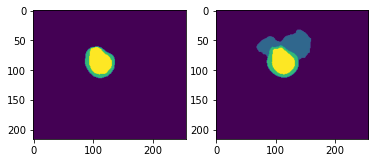

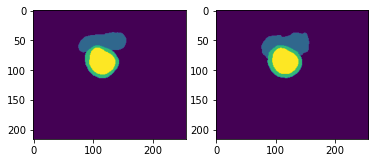

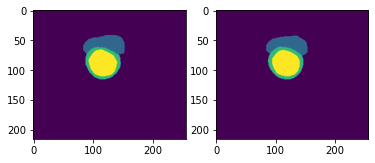

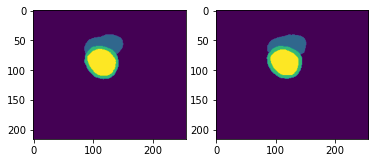

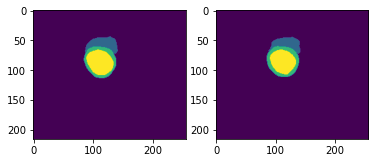

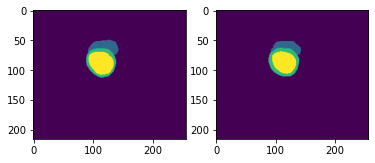

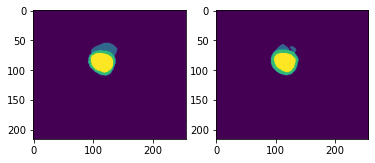

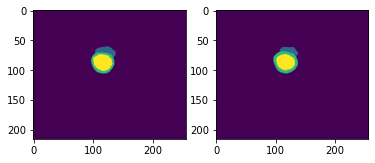

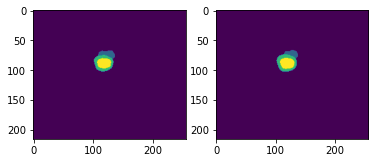

In [68]:

def main(path_gt, path_pred):
    """
    Main function to select which method to apply on the input parameters.
    """
    if os.path.isfile(path_gt) and os.path.isfile(path_pred):
        compute_metrics_on_files(path_gt, path_pred)
    elif os.path.isdir(path_gt) and os.path.isdir(path_pred):
        compute_metrics_on_directories(path_gt, path_pred)
    else:
        raise ValueError(
            "The paths given needs to be two directories or two files.")

ids = 20
if __name__ == "__main__":
#     main('dataset/ACDC_Dataset/testing/patient150\\patient150_frame12.nii.gz', 
#          'dataset/ACDC_Dataset/testing_pred/patient150\\patient150_frame12.nii.gz')
#     main('dataset/ACDC_Dataset/testing/', 
#          'dataset/ACDC_Dataset/testing_pred/')
    main(mygt[ids], 
         mypred[ids])